# Vision Zero Notebook - EDA

### Authors: Aisling Casey

### Last Updated: May 30, 2021

The purpose of this notebook is to explore the crash data, see where the data needs attention, and look for patterns before creating a vison zero model. Part of Issue #89: https://github.com/CharlotteJackson/DC_Crash_Bot/issues/89

Anyone can hop on and add their own data explorations. As you do, please add your summaries & new issues to sections 6 & 7 and the Author's list.

When the notebook is run, the roadway blocks data is available as the data frame 'rb_distance' and the crash data between 2015 and 2021 is available as 'df_crashes'

* [1. Load Data](#1.LoadData)
* [2. Calculate Block Distance](#2.CalculateBlockDistance)
* [3. Handle Missing Data](#3.HandleMissingData)
* [4. Define Data Manipulation Functions](#4.DefineDataManipulationFunctions)
* [5. Plots](#5.Plots)
    * [5.a. Feature vs Mileage](#5.a.FeaturevsMileage)
    * [5.b. Speed](#5.b.Speed)
* [6. Insights So Far](#6.InsightsSoFar)
* [7. To Do List](#7.ToDoList)

## 1. Load Data <a class="anchor" id="1.LoadData"></a>

In [1]:
import shapely
import pandas as pd
import geopandas as gpd
from geopy.distance import distance
import psycopg2
import sys, os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.io.sql as psql
import warnings
warnings.filterwarnings('ignore')
import SQL_cred
#Note: SQL cred must be created with the SQL credentials given to you by Charlotte, the database manager, to load data from
#the database into this notebook. It should be a .py file with the following format:
#PGHOST=##
#PGDATABASE=##
#PGUSER=##
#port=##
#PGPASSWORD=##

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns=100000

In [3]:
#Set SQL Address, Create SQL import function 'load_data'
conn_string = "host="+ SQL_cred.PGHOST +" port="+ "5432" +" dbname="+ SQL_cred.PGDATABASE +" user=" + SQL_cred.PGUSER \
+" password="+ SQL_cred.PGPASSWORD

def load_data(query):

    sql_command = query
    print (sql_command)

    # Load the data
    data = pd.read_sql(sql_command, conn)

    print(data.shape)
    return (data)

In [4]:
#Select all roadwayblocks data
conn=psycopg2.connect(conn_string)
query="SELECT * FROM analysis_data.roadway_blocks"
cursor = conn.cursor()
rb=load_data(query)

SELECT * FROM analysis_data.roadway_blocks
(13750, 101)


In [5]:
#Load Crash Data from 2015-2021
conn=psycopg2.connect(conn_string)
query="SELECT * FROM analysis_data.dc_crashes_w_details WHERE EXTRACT (year FROM fromdate) BETWEEN 2015 AND 2021"
cursor = conn.cursor()
df_crashes=load_data(query)

SELECT * FROM analysis_data.dc_crashes_w_details WHERE EXTRACT (year FROM fromdate) BETWEEN 2015 AND 2021
(154984, 85)


## 2. Calculate Block Distance <a class="anchor" id="2.CalculateBlockDistance"></a>

In [6]:
#Function from Calculate_Distances_of_Roadway_Blocks.ipynb 
def calculate_linestring_distance(row):
    """
    For one row in a GeoPandas GeoDataFrame, calculate the distance in both miles and meters
    of the LineString geography and save the distances to columns in the GeoDataFrame.
    
    Use this function in an .apply() statement, row-wise, like so:
    rb_shp = rb_shp.apply(calculate_linestring_distance, axis=1)
    
    The row's `geometry` field must not be None, and be a LineString (there is one 
    MultiLineString in the DC street data). In those cases, the distances are set to zero.
    """
    
    geom = row['geometry']
    miles_in_block = 0
    meters_in_block = 0
    
    if geom and isinstance(geom, shapely.geometry.linestring.LineString):
        
        # Iterate through every point in the LineString, calculating distance to the previous point
        for idx, pnt in enumerate(geom.coords):
            if idx > 0:
                segment_distance = distance(
                    (geom.coords[idx-1][1], geom.coords[idx-1][0])
                    , (geom.coords[idx][1], geom.coords[idx][0])
                )
                miles_in_block += segment_distance.miles
                meters_in_block += segment_distance.meters

    row['distance_miles'] = miles_in_block
    row['distance_meters'] = meters_in_block
    
    return row

In [7]:
#Downloaded from https://opendata.dc.gov/datasets/DCGIS::roadway-block/about
rb_shp = gpd.read_file('Roadway_Block/Roadway_Block.shp')
rb_shp = rb_shp.apply(calculate_linestring_distance, axis=1)

In [8]:
#Right now, the roadwayblocks data in database doesn't have the same OBJECT id as that of the roadway block
#Joining on blockkey for now; will want to switch back to objectid eventually 
rb_distance = pd.merge(rb, rb_shp[['BLOCKKEY', 'ROUTENAME','FROMSTREET', 'TOSTREET', 'distance_miles', 'distance_meters']], how='inner', left_on='blockkey', right_on='BLOCKKEY')

In [9]:
#These are blocks in the .shp data that aren't in the roadwayblock data
h=rb_shp.BLOCKKEY.isin(rb.blockkey)
print(len(rb[~h]))
rb_shp[~h]

53


,OBJECTID,ROUTEID,FROMMEASUR,TOMEASURE,ROUTENAME,ROADTYPE,BLOCKKEY,TOTALTRAVE,TOTALPARKI,TOTALRAISE,TOTALTRA_1,TOTALCROSS,TOTALPAR_1,TOTALRAI_1,TOTALTRA_2,TOTALTRA_3,TOTALTRA_4,TOTALTRA_5,SUMMARYDIR,BIKELANE_P,BIKELANE_T,BIKELANE_1,BIKELANE_C,BIKELANE_2,BIKELANE_D,BIKELANE_3,BIKELANE_B,DOUBLEYELL,SECTIONFLA,LOC_ERROR,MIDMEASURE,AADT,AADT_YEAR,FHWAFUNCTI,HPMSID,HPMSSECTIO,ID,IRI,IRI_DATE,NHSCODE,OWNERSHIP,PCI_CONDCA,PCI_LASTIN,PCI_SCORE,QUADRANT,SIDEWALK_I,SIDEWALK_1,SIDEWALK_O,SIDEWALK_2,SPEEDLIMIT,SPEEDLIM_1,SPEEDLIM_2,SPEEDLIM_3,STREETNAME,STREETTYPE,BLOCK_NAME,ADDRESS_RA,ADDRESS__1,ADDRESS__2,ADDRESS__3,ADDRESS__4,MAR_ID,ADDRESS__5,BLOCKID,DCFUNCTION,NHSTYPE,SNOWROUTE_,SNOWROUT_1,SNOWSECTIO,SNOWZONE_D,SNOWZONE_1,LEFTTURN_C,LEFTTURN_1,RIGHTTURN_,RIGHTTUR_1,TOTALBIKEL,TOTALBIK_1,RPPDIRECTI,RPPSIDE,SLOWSTREET,BIKELANE_4,RIGHTTUR_2,LEFTTURN_E,BUSLANE_IN,BUSLANE_OU,FROMSTREET,TOSTREET,WARD_ID,ANC_ID,SMD_ID,SHAPELEN,SHAPE,geometry,distance_miles,distance_meters
15,167034,15048431,2600.654053,2608.543701,INTERSTATE 66 BN,1,dc1fff6bb528d73248a6f64b653b89a8,1,0,0,12,29,0,0,0,1,0,0,OB,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,51949.0,2019.0,2.0,2221,1.0,5fbff77e-dc0f-4e0e-8a89-c306b4468c76,203.0,2014-12-01,1.0,1,Fair,2019-11-16,55.0,5.0,None,None,None,None,NaN,NaN,45.0,NaN,INTERSTATE 66,I,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15048431-11050892_15048431-11003002_11093212_1...,12.0,NHS Non-Interstate,INTERSTATE 66 BN,NHS-6,F3,6,6,None,0,None,0,0,0,None,None,None,None,None,None,None,None,K ST NW,30TH ST NW/WHITEHURST FWY NW/WHITEHURST FWY NW...,None,None,None,0,None,"LINESTRING Z (-77.05902 38.90260 0.00000, -77....",0.004903,7.889930
269,167288,11093212,266.608185,1315.859131,WHITEHURST FWY NW,1,2f90b97c7af868e78954054da4c15070,4,0,3,44,66,0,14,2,2,0,0,BD,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,41841.0,2019.0,2.0,2210,1.0,f4076de2-911a-4ad6-82e3-57e3077c7594,98.0,2014-03-01,1.0,1,Excellent,2019-11-15,100.0,1.0,None,None,None,None,20.0,NaN,20.0,NaN,WHITEHURST,FWY,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11093212-11003002_11093212_11093212A_11093212A...,12.0,NHS Non-Interstate,WHITEHURST FWY NW,NHS-6,F3,6,3,None,0,None,0,0,0,None,None,None,None,None,None,None,None,30TH ST NW/WHITEHURST FWY NW/WHITEHURST FWY NW...,36TH ST NW/M ST NW,None,None,None,0,None,"LINESTRING Z (-77.05911 38.90257 0.00000, -77....",0.652007,1049.304118
1033,168052,15048461,4495.689941,4797.428711,INTERSTATE 395 BN,1,49ae65193aa44a34a92febee55dc8ce2,2,0,1,24,52,0,16,0,2,0,0,OB,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,55931.0,2019.0,1.0,1503,1.0,316c9446-1244-453e-84e7-179a086376cb,186.0,2014-01-01,1.0,1,Excellent,2019-11-11,93.0,5.0,None,None,None,None,NaN,NaN,20.0,NaN,INTERSTATE 395,I,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15048461-11050892_15048461-11064672_15048461,11.0,NHS Interstate,INTERSTATE 295 I BN,NHS-5,E4,5,5,None,0,None,0,0,0,None,None,None,None,None,None,None,None,K ST NW,NEW YORK AVE NW,None,None,None,0,None,"LINESTRING Z (-77.01455 38.90253 0.00000, -77....",0.187501,301.753288
1178,168197,15048431,1332.604004,2203.775879,INTERSTATE 66 BN,1,806291e36a8e5cabfa6301ad598df521,4,0,0,44,44,0,0,0,4,0,0,OB,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,34208.0,2019.0,1.0,1205,1.0,a6c692a9-be1b-4b88-ae64-3dfdfd675227,198.0,2014-12-01,1.0,1,Fair,2019-11-16,55.0,5.0,None,None,None,None,NaN,NaN,45.0,NaN,INTERSTATE 66,I,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15048431-15048431_15048431A-11050892_15048431*1,11.0,NHS Interstate,INTERSTATE 66 BN,NHS-6,F2,6,6,None,0,None,0,0,0,None,None,None,None,None,None,None,None,INTERSTATE 66 BN,K ST NW,None,None,None,0,None,"LINESTRING Z (-77.05375 38.89540 0.00000, -77....",0.541349,871.216154
1883,168902,15048461,1798.464233,4495.689941,INTERSTATE 395 BN,1,9f801fd603c4c06826328a0e138646c8,3,0,0,35,51,0,0,0,3,0,0,OB,None,None,None,None,None,None,None,None,None,"SectionTy

In [10]:
#These are blocks in the roadwayblock data that aren't in the shp file
g=rb.blockkey.isin(rb_shp.BLOCKKEY)
#g=rb.id.isin(rb_shp.BLOCKID)
print(len(rb[~g]))
rb[~g]

31


,near_schools,es,ms,hs,public_school,charter_school,anc_id,nbh_cluster,nbh_cluster_names,smd_id,ward_name,census_tract,comp_plan_area,objectid,routeid,frommeasure,tomeasure,routename,roadtype,blockkey,totaltravellanes,totalparkinglanes,totalraisedbuffers,totaltravellanewidth,totalcrosssectionwidth,totalparkinglanewidth,totalraisedbufferwidth,totaltravellanesinbound,totaltravellanesoutbound,totaltravellanesbidirectional,totaltravellanesreversible,summarydirection,bikelane_parkinglane_adjacent,bikelane_throughlane_adjacent,bikelane_pocketlane_adjacent,bikelane_contraflow,bikelane_conventional,bikelane_dual_protected,bieklane_dual_buffered,bikelane_protected,bikelane_buffered,doubleyellow_line,sectionflags,loc_error,midmeasure,aadt,aadt_year,fhwafunctionalclass,hpmsid,hpmssectiontype,id,iri,iri_date,nhscode,ownership,pci_condcategory,pci_lastinspected,pci_score,quadrant,sidewalk_ib_pavtype,sidewalk_ib_width,sidewalk_ob_pavtype,sidewalk_ob_width,speedlimits_ib,speedlimits_ib_alt,speedlimits_ob,speedlimits_ob_alt,streetname,streettype,block_name,address_range_high,address_range_low,address_range_right_high,address_range_left_high,address_range_right_low,mar_id,address_range_left_low,blockid,dcfunctionalclass,nhstype,snowroute_ddot,snowroute_dpw,snowsection_ddot,snowzone_ddot,snowzone_dpw,leftturn_curblane_excl,leftturn_curblane_excl_len,rightturn_curblane_excl,rightturn_curblane_excl_len,totalbikelanes,totalbikelanewidth,rppdirection,rppside,slowstreetinfo,shapelen,shape,geography,num_sides_w_sidewalks,sidewalk_width,speed_limit,dcfunctionalclass_desc
926,[None],NaN,NaN,NaN,NaN,NaN,2A,Cluster 5,"West End, Foggy Bottom, GWU",2A03,Ward 2,005600,NEAR NORTHWEST,125799,11050892,3835.548584,4078.399658,K ST NW,1,73185c8dc4837467a2199f7765ae0a7b,4.0,0.0,2.0,54.0,62.0,0.0,8.0,2.0,2.0,0.0,0.0,BD,None,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,26985.0,2019.0,3.0,7055,2.0,21a3b872-3c6c-499e-a4f4-ec08930124f3,4.0,2017-10-01 00:00:00+00:00,1.0,1,Poor,2020-01-05 00:00:00+00:00,45.0,1,3 (JPCP),11,None,None,25.0,None,25.0,None,K,ST,2500 - 2699 BLOCK OF K STREET NW,2699.0,2500.0,2699.0,2698.0,2501.0,813620.0,2500.0,11050892-11002502_11050892-11002702_11050892_1...,14.0,NHS Non-Interstate,K ST NW,NHS-2,B1,2,6,None,0.0,None,0.0,0.0,0.0,3,B,None,0.0,None,0102000020E6100000040000007F982767694353C0F8DF...,1,11,25.0,Principal Arterial
930,[None],NaN,NaN,NaN,NaN,NaN,2A,Cluster 5,"West End, Foggy Bottom, GWU",2A03,Ward 2,005600,NEAR NORTHWEST,126727,11002402,359.946198,566.457275,24TH ST NW,1,dcf0ae3ecc26fe32350d0dac5fa9f337,2.0,2.0,0.0,16.0,32.0,16.0,0.0,1.0,1.0,0.0,0.0,BD,None,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,3756.0,2019.0,5.0,1024017A,2.0,31a21d85-f2a5-4b7e-8d6a-cec5e5c25dda,269.0,2017-11-01 00:00:00+00:00,NaN,1,Good,2019-09-13 00:00:00+00:00,71.0,1,12 (Brick),12,12 (Brick),14,25.0,None,20.0,None,24TH,ST,900 - 1010 BLOCK OF 24TH STREET NW,1010.0,900.0,1009.0,1010.0,901.0,813371.0,900.0,11002402-11002402_11064222-11002402_11069812_3...,17.0,None,None,LP-601,None,None,6,None,0.0,None,0.0,0.0,0.0,3,B,None,0.0,None,0102000020E610000010000000F11EFC8D4A4353C0D59C...,2,12,25.0,Collector
937,[None],NaN,NaN,NaN,NaN,NaN,2A,Cluster 5,"West End, Foggy Bottom, GWU",2A03,Ward 2,005600,NEAR NORTHWEST,134716,11093212A,0.000000,263.993408,WHITEHURST FWY NW,1,f6f7155e0fb8c02ddb4b5b38f71e533e,2.0,0.0,1.0,21.0,30.0,0.0,9.0,0.0,2.0,0.0,0.0,OB,None,None,None,None,None,None,None,None,None,None,"SectionType_19 Not Defined,",NO ERROR,None,24045.0,2019.0,2.0,6031,2.0,92e82842-e594-48c1-b193-7230cbe20eaa,205.0,2017-10-01 00:00:00+00:00,1.0,1,Excellent,2019-11-15 00:00:00+00:00,100.0,1,None,None,None,None,NaN,None,20.0,None,WHITEHURST,FWY,0 - 0 BLOCK OF WHITEHURST FREEWAY NW,0.0,0.0,0.0,0.0,0.0,807006.0,0.0,11093212A-11002702_11050892_11093212_11093212A...,12.0,NHS Non-Interstate,WHITEHURST FWY NW,NHS-6,F3,6,3,None,0.0,None,0.0,0.0,0.0,None,None,None,0.0,None,0102000020E6100000200

In [11]:
#Difference in overall mileage between roadway blocks database data and shp file
#Only 9 miles - will prodceed with rb_distance for now
rb_shp.distance_miles.sum(), rb_distance.distance_miles.sum()

(1173.8108141892626, 1165.294153395879)

## 3. Handle Missing Data <a class="anchor" id="3.HandleMissingData"></a>

In [12]:
#Deal with missing data for features of interest in roadway blocks data

# Add functional class descriptions for three roads that are missing it
rb_distance.loc[rb_distance.ROUTENAME=='R ST SW','dcfunctionalclass_desc']='Local'
rb_distance.loc[rb_distance.ROUTENAME=='DOUGLASS RD SE','dcfunctionalclass_desc']='Local'

#Fill Missing AADT with 100
#Lowest AADT for is 149, so an avg of 100 here seems reasonable. 
rb_distance.aadt.fillna(value=100,inplace=True)

#Rows to fill NaN
fill_nan_rows=[
'bikelane_parkinglane_adjacent',
'bikelane_throughlane_adjacent',
'bikelane_pocketlane_adjacent',
'bikelane_contraflow',
'bikelane_conventional',
'bikelane_dual_protected',
'bieklane_dual_buffered',
'bikelane_protected',
'bikelane_buffered',
'doubleyellow_line',
'sidewalk_ib_pavtype',
'sidewalk_ib_width',
'sidewalk_ob_pavtype',
'sidewalk_ob_width']

#Fill with 'None' if string, '0' if int
for i in fill_nan_rows:
    if rb_distance[i].dtype=='O':
        rb_distance[i].fillna(value='None',inplace=True)
    else:
        rb_distance[i].fillna(value=0,inplace=True)
        
#Drop column if it doesn't have all rows available 
rb_distance.dropna(axis=1,how='any',inplace=True)
        
#Admire your work
rb_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13719 entries, 0 to 13718
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   near_schools                   13719 non-null  object             
 1   objectid                       13719 non-null  object             
 2   routeid                        13719 non-null  object             
 3   frommeasure                    13719 non-null  float64            
 4   tomeasure                      13719 non-null  float64            
 5   routename                      13719 non-null  object             
 6   roadtype                       13719 non-null  object             
 7   blockkey                       13719 non-null  object             
 8   totaltravellanes               13719 non-null  float64            
 9   totalparkinglanes              13719 non-null  float64            
 10  totalraisedbuffers    

## 4. Define Data Manipulation Functions <a class="anchor" id="4.DefineDataManipulationFunctions"></a>

In [13]:
DC_Miles_Length=rb_distance.distance_miles.sum()
def distance_proportion(df, variable_list):
    #This function calculates the proportion that each given feature exists on DC roads - 
    #e.g. 60% of all roadway in DC is local roads, 15% is minor arterial, etc
    #Input: Roadway blocks dataframe, list of features to calculate the proportions for
    #Returns: Dictionary with feature name as main key, 
    #then feature variables as the subkeys and the DC proportion as their values
    proportional_val={}
    for i in variable_list:
        values_i={}
        ind=df.groupby(i).distance_miles.sum().index
        val=df.groupby(i).distance_miles.sum().values
        val=[round((j/DC_Miles_Length)*100,3) for j in list (val)]
        for ind,val in zip (ind,val):
            values_i[ind]=val
        proportional_val[i]=values_i
    return proportional_val

In [14]:
variable_list=[
'totaltravellanes',
'totalparkinglanes',
'totalraisedbuffers',
'totaltravellanewidth',
'totalcrosssectionwidth',
'totalparkinglanewidth',
'totalraisedbufferwidth',
'totaltravellanesinbound',
'totaltravellanesoutbound',
'totaltravellanesbidirectional',
'totaltravellanesreversible',
'summarydirection',
'bikelane_parkinglane_adjacent',
'bikelane_throughlane_adjacent',
'bikelane_pocketlane_adjacent',
'bikelane_contraflow',
'bikelane_conventional',
'bikelane_dual_protected',
'bieklane_dual_buffered',
'bikelane_protected',
'bikelane_buffered',
'doubleyellow_line',
'sidewalk_ib_pavtype',
'sidewalk_ib_width',
'sidewalk_ob_pavtype',
'sidewalk_ob_width',
'totalbikelanes',
'totalbikelanewidth',
'num_sides_w_sidewalks',
'dcfunctionalclass_desc']

In [15]:
proportional_val=distance_proportion(rb_distance,variable_list)

In [28]:
def distribution_by_incident_type(target,df):
    #This function plots a barplot of the proportion (by street mileage) of a feature in DC vs Traffic Indicents with injury
    df_sub=df.loc[:,[target,'bicycle_injuries','pedestrian_injuries','vehicle_injuries']].copy()
    df_sub.pedestrian_injuries=df_sub.pedestrian_injuries.astype(bool)
    df_sub.vehicle_injuries=df_sub.vehicle_injuries.astype(bool)
    df_sub.bicycle_injuries=df_sub.bicycle_injuries.astype(bool)
    df_sub=df_sub.groupby(target)['bicycle_injuries','pedestrian_injuries','vehicle_injuries'].sum()
    df_pct=df_sub.apply(lambda x: round(x/np.sum(x)*100,2)).reset_index()
    df_merge=pd.DataFrame.from_dict(proportional_val[target],orient='index',columns=['DC Streets %']).reset_index().rename(columns={'index':target})
    df_pct=df_pct.merge(df_merge,on=target,how='outer')
    #Melt Data Frame for Plotting 
    df_sub_melted=pd.melt(df_pct,id_vars=target,var_name='Type',value_name='PCT')
    df_sub_melted
    #Plot Data 
    plt.subplots(figsize=(12,8))
    sns.barplot(x=target,y='PCT',hue='Type',data=df_sub_melted)
    plt.title(target+' vs Traffic Incidents with Injury - Normalized ')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 5. Plots <a class="anchor" id="5.Plots"></a>

### 5.a. Feature vs Mileage <a class="anchor" id="5.a.FeaturevsMileage"></a>

In [29]:
df_crashes.sidewalk_width.value_counts(dropna=False)

6      45513
NaN    19226
16+    18637
7      12580
8      10376
10      9511
12      9396
5       8182
9       7258
11      4219
14      3266
15      2455
4       2450
13      1801
3        106
2          8
Name: sidewalk_width, dtype: int64

In [30]:
#Must check that the NaNs from crash data are filled in as their own category 
df_crashes.num_sides_w_sidewalks.value_counts(dropna=False)

2    123447
0     19139
1     12398
Name: num_sides_w_sidewalks, dtype: int64

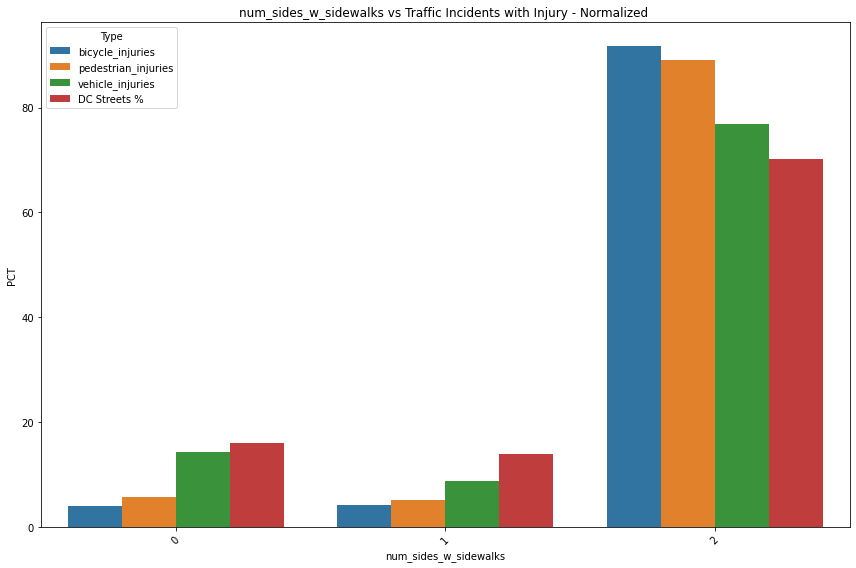

In [31]:
target='num_sides_w_sidewalks'
distribution_by_incident_type(target,df_crashes)

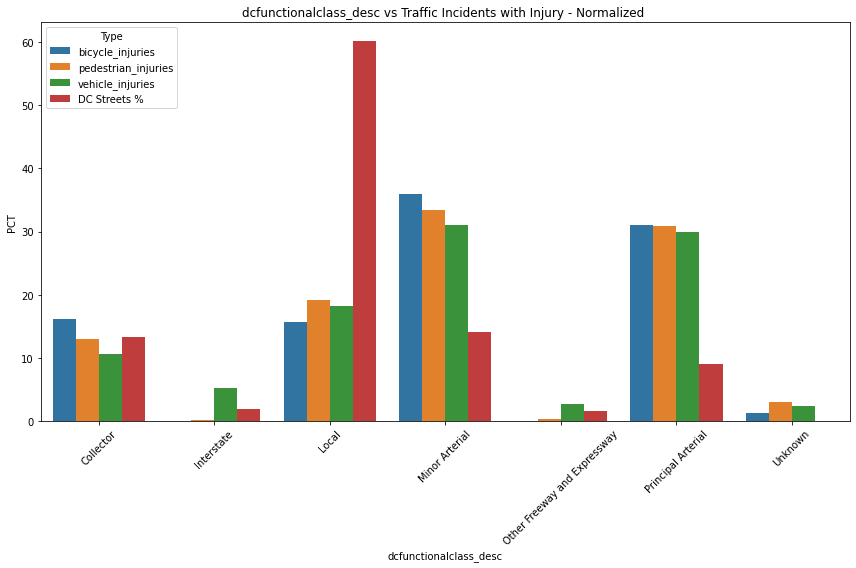

In [32]:
#Fill missing functional class desc with Unknown
df_crashes.dcfunctionalclass_desc.fillna(value='Unknown',inplace=True)
target='dcfunctionalclass_desc'
distribution_by_incident_type(target,df_crashes)

In [33]:
#Must check that the NaNs from crash data are filled in as their own category 
df_crashes.totaltravellanes.value_counts(dropna=False)

2.0     57677
4.0     39965
3.0     14956
1.0     12940
6.0     12106
5.0      8461
NaN      4301
7.0      2928
8.0      1118
0.0       406
10.0      126
Name: totaltravellanes, dtype: int64

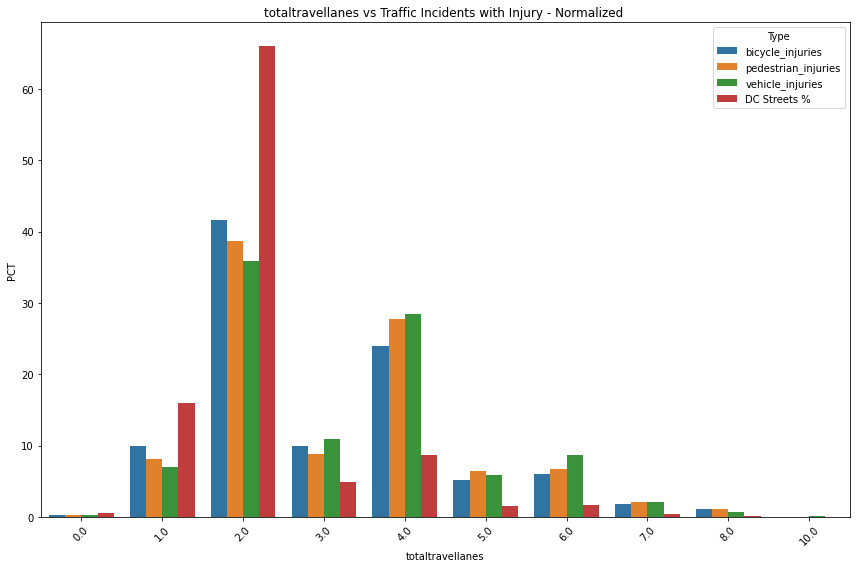

In [34]:
#Not sure how to handle these data points at this time; will just leave them out of the graph
target='totaltravellanes'
distribution_by_incident_type(target,df_crashes)

In [35]:
#Must check that the NaNs from crash data are filled in as their own category 
df_crashes.doubleyellow_line.value_counts(dropna=False)

None    88175
Yes     66809
Name: doubleyellow_line, dtype: int64

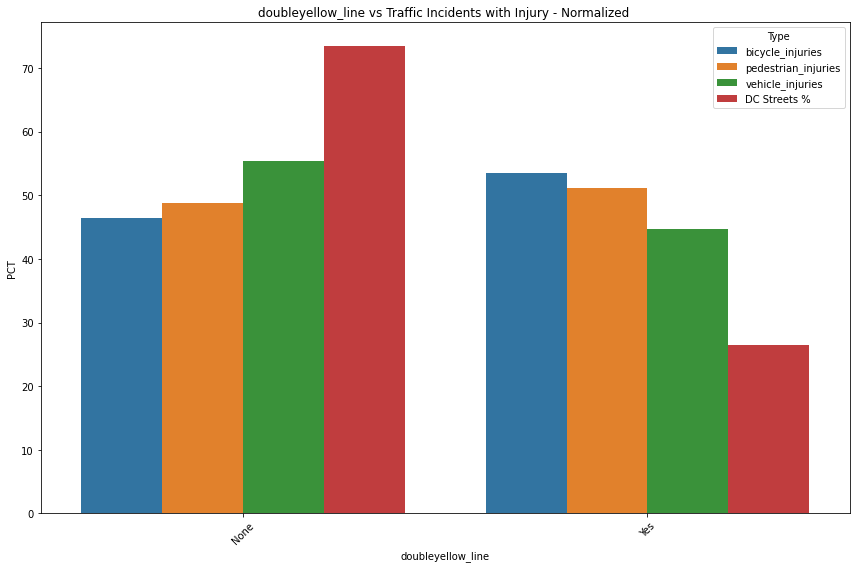

In [36]:
#Fill missing double yellow line with 'No'
df_crashes.doubleyellow_line.fillna(value='None',inplace=True)
target='doubleyellow_line'
distribution_by_incident_type(target,df_crashes)

### 5.b. Speed <a class="anchor" id="5.b.Speed"></a>

In [37]:
#Make a copy of the dataframe
df_speed=df_crashes.copy()
#Add Indicator Columns for whether or not a crash occured
df_speed.pedestrian_injuries=df_speed.pedestrian_injuries.astype(bool)
df_speed.vehicle_injuries=df_speed.vehicle_injuries.astype(bool)
df_speed.bicycle_injuries=df_speed.bicycle_injuries.astype(bool)
#Print value counts of injury types - will check against latter
df_speed[['pedestrian_injuries','bicycle_injuries','vehicle_injuries']].sum()

pedestrian_injuries     5255
bicycle_injuries        2860
vehicle_injuries       44295
dtype: int64

In [38]:
#Limit the dataframe to variables of interest
df_speed=df_speed[['pedestrian_injuries','bicycle_injuries','vehicle_injuries','speed_limit']]
#Melt the data frame to make type of accident its own variable 
df_speed=df_speed.melt(id_vars='speed_limit',value_vars=['pedestrian_injuries','bicycle_injuries','vehicle_injuries'],var_name='Accident_type')
#Only keep rows where crashes occured - use type of accident as a boolean filter
df_speed=df_speed[df_speed.value.values]
#Check that the types of accident counts are the same as above
df_speed.Accident_type.value_counts()

vehicle_injuries       44295
pedestrian_injuries     5255
bicycle_injuries        2860
Name: Accident_type, dtype: int64

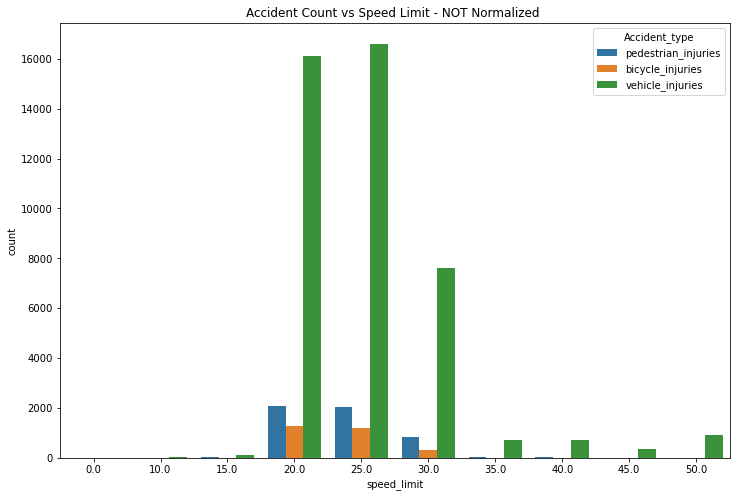

In [39]:
plt.subplots(figsize=(12,8))
sns.countplot(x='speed_limit',hue='Accident_type',data=df_speed)
plt.title('Accident Count vs Speed Limit - NOT Normalized ')
plt.show()

## 6. Insights So Far <a class="anchor" id="6.InsightsSoFar"></a>

- Principal & Minor roads make up less than 30% of the roads in DC, but over 60% of crashes occur on them
- Roads with 3 or more lanes have a disprortionately high crash # compared to their presence in the city (which reflects the the arterial roads). 
- Perhaps counterintuitively, with current data available, it appears that pedestrian crashes happen at a lower proportion on roads with 0 or 1 sidewalks compared to their presence in the city vs. 2 sidewalks.
- The  vast majority of crashes, whether pedestrian, bicycle or vehicle happen on roads with speed limits of 20, 25 or 30 MPH
- Crash types (bicycle, ped, vehicle) proportions relatively equal across road type, # of travel lanes

## 7. To Do List <a class="anchor" id="7.ToDoList"></a>

### In Notebook 
- Make more data visualizations - Added 5/30
    - Explore aadt (Traffic Volume) vs number of crashes on roads to identify outliers. Note that aadt is not available for local roads. - Added 5/30
    - When more feature
- Identify key variables in roadway crashes- Added 5/30
- Feature Engineering- Added 5/30

### In Database
- See What's going on with roadway blocks data. Right now, the .shp file downloaded from [Open Data DC](https://opendata.dc.gov/datasets/roadway-block/explore?location=38.894250%2C-77.013050%2C12.32) does not match up with what's in the database on objectid as it used to. Using blockkey instead, but at leat 80 records not matching up. - Added 5/30

- Get more features from roadway blocks into the crash data (e.g. raised buffer, bike lane protected) - Added 5/30

- Get missing data for roadway blocks data- Added 5/30
    - Speed Limit (in source data)
    - Walk & Bike Score 


### Completed
- Function to calculate proportion of feature on DC roads
- Bar plots of proportion of feature on DC road vs road type, # travel lanes, # of sidewalks, double yellow line presence